In [ ]:
# default_exp background_distributions

# Calculating Background Distributions
In order to differentially assess changes of ions/peptides/proteins between conditions, assumptions about the underlying distributions have to be made. This is necessary to distinguish systematic regulation between conditons from random noise. As introduced in the [MS-EmpiRe paper](https://doi.org/10.1074/mcp.RA119.001509) and refined in the [EmpiReS paper](https://doi.org/10.1101/2020.08.23.234237 ), replicate measurements can be utilized to estimate the empirical *background distributions*, which should reflect the noise underlying the measurements. This approach can then be utilized to:
* estimate the background distribtuions in each condition
* estimate the background in condition1 - condition2 (i.e. the distribution of fold changes between conditions)
* the previous two approaches suffice to perform differential quantification. The approach can however also be used for more complex scenarios. For example, if we want to compare, if two peptides change differently from each other, between two conditions, we can also estimate the underlying background (condition1-condition2)_peptide1 - (condition1-condition2)_peptide2

## Capturing the background of an experimental condition

In the context of AlphaQuant, where proteomics measurements are analysed, we use the word *condition* to describe a set of measurments that was acquired to capture a certain biological state (eg. condition "native" as opposed to conditon "heat shock"). We try to characterize conditions by sorting their ions by mean intensity (intensity is a good predictor for variation, as described in the [MS-EmpiRe paper](https://doi.org/10.1074/mcp.RA119.001509)) and then creating a set of background distributions over the whole intensity range. As a result, we can assign a background distribution to each ion as well as each *differential ion* (i.e. the expected variation in the fold changes of this ion).


In [ ]:
#export
from time import time
import numpy as np
import alphaquant.diffquant_utils as aqutils
class ConditionBackgrounds():

    def __init__(self, normed_condition_df, p2z):
        self.backgrounds = []
        self.ion2background = {}
        self.ion2nonNanvals = {}
        self.ion2allvals = {}
        self.idx2ion = {}
        self.init_ion2nonNanvals(normed_condition_df)
        t_start = time()
        self.context_ranges = []
        self.select_intensity_ranges(p2z)
        t_intensity_selection = time()
        print(f't_intensity_selection {t_intensity_selection - t_start}')


    def init_ion2nonNanvals(self, normed_condition_df):
        normed_condition_df['median'] = normed_condition_df.median(numeric_only=True, axis=1)
        normed_condition_df = normed_condition_df.sort_values(by='median').drop('median', axis=1)
        self.normed_condition_df = normed_condition_df
        #nonan_array = get_nonna_array(normed_condition_df.to_numpy())
        #self.ion2nonNanvals = dict(zip(normed_condition_df.index, nonan_array))
        t_start = time()
        self.ion2nonNanvals = aqutils.get_non_nas_from_pd_df(normed_condition_df)
        self.ion2allvals = aqutils.get_ionints_from_pd_df(normed_condition_df)
        t_end = time()
        print(f't_ion2nonan_sw {t_end - t_start}')
        self.idx2ion = dict(zip(range(len(normed_condition_df.index)), normed_condition_df.index))


    def select_intensity_ranges(self, p2z):
        total_available_comparisons =0
        num_contexts = 10
        cumulative_counts = np.zeros(self.normed_condition_df.shape[0])

        for idx ,count in enumerate(self.normed_condition_df.count(axis=1)):
            total_available_comparisons+=count-1
            cumulative_counts[idx] = int(total_available_comparisons/2)


        #assign the context sizes
        context_size = np.max([1000, int(total_available_comparisons/(1+num_contexts/2))])
        if context_size> total_available_comparisons:
            context_size = int(total_available_comparisons/2)
        halfcontext_size = int(context_size/2)
        context_boundaries = np.zeros(3).astype(int)

        middle_idx = int(np.searchsorted(cumulative_counts, halfcontext_size))
        end_idx = int(np.searchsorted(cumulative_counts, context_size))


        context_boundaries[0] = 0
        context_boundaries[1] = middle_idx
        context_boundaries[2] = end_idx
        while context_boundaries[1] < len(cumulative_counts):
            bgdist = BackGroundDistribution(context_boundaries[0], context_boundaries[2], self.ion2nonNanvals, self.idx2ion, p2z)
            self.context_ranges.append([context_boundaries[0], context_boundaries[2]])
            self.assign_ions2bgdists(context_boundaries[0], context_boundaries[2], bgdist)
            self.backgrounds.append(bgdist)
            context_boundaries[0] = context_boundaries[1]
            context_boundaries[1] = context_boundaries[2]
            end_idx = np.searchsorted(cumulative_counts, context_size + cumulative_counts[context_boundaries[0]])
            if end_idx > len(cumulative_counts)-(context_boundaries[1]-context_boundaries[0])/1.5:
                end_idx = len(cumulative_counts)
            context_boundaries[2] = end_idx

    def assign_ions2bgdists(self, boundaries1, boundaries2, bgdist):
        ion2bg_local = {} #dict(map(lambda _idx : (self.normed_condition_df.index.values[_idx], bgdist), range(boundaries1, boundaries2)))
        for idx in range(boundaries1, boundaries2):
            ion2bg_local.update({self.idx2ion.get(idx) : bgdist})
        self.ion2background.update(ion2bg_local)

## Estimate the Background Distribution for a given set of quantified ions
The BackGroundDistribution object is created for a subset of ions. The sets of ions are chosen such that we can assume a certain similarity in how they are distributed (see also notes to the ConditionBackground below). The essential information the BackGroundDistribution object receives is a list of ions with their measured intensity values. The background distribution is constructed from these values in two steps:

1. For each ion, randomly select one of the intensities and subtract if from the other intensites. This rescales the values to fold change values.
2. Subsequently, compare the differences in the rescaled values between different ions. This gives an estimate of the variation of the whole distribution.

We  directly derive some basic properties of the distribution and transform it into a 2d representation (binned fc value vs. counts) for memory efficiency. We also transform the distribution into a cumulative one and subsequently transform this distribution into a z-value distribution for quick lookups

In [ ]:
#export
import numpy as np
import random
import pandas as pd
from statistics import NormalDist
import math
from time import time
import typing
from numba import njit

class BackGroundDistribution:
    """Represents and derives an empirical distribution to describe the variation underlying a measurment
    """
    fc_resolution_factor = 100
    fc_conversion_factor = 1/fc_resolution_factor

    def __init__(self, start_idx : int, end_idx: int, ion2noNanvals : typing.Dict[int, str], idx2ion : dict,p2z : dict):

        """
        Initialize the background distribution from a subset of selected ions. The ions are pre-ordered and indexed and a sub range is selected. The 
        Background Distribution is created from the sub-range.
        Args:
            start_idx (int): determines the start of sub-range
            end_idx (int): determines the end of the sub-range
            ion2noNanvals (dict): maps the ion to all measured intensities of this ion (no NAs/zero measurements)
            idx2ion (dict): distinct mapping of the index to the ion name
            p2z (dict): p-values are transformed into z-values on many occasions and are therefore cached with this dictionary.
        """
        self.fc2counts = {} #binned Fold change Distribution
        self.cumulative = np.array([])
        self.zscores = np.array([])
        self.min_fc =0
        self.max_fc = 0
        self.min_z=0
        self.max_z=0
        self.start_idx = int(start_idx)
        self.end_idx = int(end_idx)
        self.var = None
        self.SD = None
        self.ions = {idx2ion.get(idx) for idx in range(start_idx, end_idx)}

        anchor_fcs = self.generate_anchorfcs_from_intensity_range(ion2noNanvals, idx2ion)
        random.Random(42).shuffle(anchor_fcs) #set seed to ensure reproducibility
        self.generate_fc2counts_from_anchor_fcs(anchor_fcs)
        self.cumulative = self.transform_fc2counts_into_cumulative()
        self.calc_SD(0, self.cumulative)
        self.zscores = self.transform_cumulative_into_z_values(p2z)
       # print(f"create dist SD {self.SD}")

    def generate_anchorfcs_from_intensity_range(self, ion2noNanvals : dict, idx2ion : dict) -> list:
        """For each ion, a random intensity is selected as an "anchor" and the remaining intensities are subtracted from the achor.

        Args:
            ion2noNanvals (dict): maps the ion to all measured intensities of this ion (no NAs/zero measurements)
            idx2ion (dict): distinct mapping of the index to the ion name

        Returns:
            list: a merged list of all fold changes relative to the anchors
        """
        rng = random.Random(0)
        anchor_fcs = []
        for idx in range(self.start_idx, self.end_idx):
            vals = ion2noNanvals[idx2ion.get(idx)]
            if vals.size < 2:
                continue
            anchor_idx =  rng.randint(0, len(vals)-1)
            anchor_val = vals[anchor_idx]
            vals = np.delete(vals, anchor_idx)
            anchor_fcs.extend(vals-anchor_val)
        return anchor_fcs

    def generate_fc2counts_from_anchor_fcs(self,anchor_fcs : list):
        """Arbitrary pairs of anchor-changes are compared with each other, in order to determine the overall variation between the ions.

        Args:
            anchor_fcs (list): input list of the anchor-changes
        
        Returns:
            updates the self.fc2counts instance variable
        """
        anchor_fcs = anchor_fcs
        for idx in range(1, len(anchor_fcs)):
            fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.int64)
            self.fc2counts[fc_binned] = self.fc2counts.get(fc_binned, 0) + 1 #the distribution is saved in 2d (binned fold changes vs. count) for memory efficiency

        self.min_fc = min(self.fc2counts.keys())
        self.max_fc = max(self.fc2counts.keys())


    def transform_fc2counts_into_cumulative(self) -> np.array(float):
        """The binned fold change distribution is encoded in a 1d array, where the coordinate of the array represents the fold change and 
        the value of the array represents the cumulative frequency.

        Returns:
            np.array: cumulative distribution of fold changes encoded in 1d array
        """
        cumulative = np.zeros(self.max_fc - self.min_fc +1).astype(np.long)

        for entry in self.fc2counts.items():
            cumulative[int(entry[0]-self.min_fc)] +=entry[1]
        for idx in range(1,cumulative.shape[0]):
            cumulative[idx] +=cumulative[idx-1]

        return cumulative


    def transform_cumulative_into_z_values(self:int, p2z: dict):
        """
        The binned fold change distribution is encoded in a 1d array, where the coordinate of the array represents the fold change and 
        the value of the array represents the z-value. For each point in the distribution, we can calculate the z-value. This value encodes the distance from 
        zero in a standard normal distribution that is required to obtain the same relative cumulative value
        
        Args:
            p2z (dict): p-values are transformed into z-values on many occasions and are therefore cached with this dictionary.

        Returns:
            np.array: array of z-values corresponding to the fold changes encoded in 1d array
        """
        total = self.cumulative[-1]
        min_pval = 1/(total+1)
        self.max_z = abs(NormalDist().inv_cdf(max(1e-9, min_pval)))
        zscores = np.zeros(len(self.cumulative))
        zero_pos = -self.min_fc

        normfact_posvals = 1/(total-self.cumulative[zero_pos]+1)
        normfact_negvals = 1/(self.cumulative[zero_pos-1]+1)
        for i in range(len(self.cumulative)):
            t_start = time()
            num_more_extreme = 0
            normfact = 0
            if i == zero_pos or i==len(self.cumulative)-1:
                zscores[i] = 0
                continue

            if i < zero_pos:
                num_more_extreme = self.cumulative[i]
                normfact = normfact_negvals
            else:
                num_more_extreme = self.cumulative[-1] - self.cumulative[i+1]
                normfact = normfact_posvals

            p_val = 0.5*max(1e-9, (num_more_extreme+1)*normfact)
            sign = -1 if i<zero_pos else 1
            t_empirical = time()
            zscore = sign*abs(get_z_from_p_empirical(p_val, p2z))
            zscores[i] =  zscore
            t_nd_lookup = time()
            #print(f"t_empirical {t_empirical - t_start} t_zcacl {t_nd_lookup - t_empirical}")
        return zscores


    def calc_zscore_from_fc(self, fc):
        return _calc_zscore_from_fc(fc, self.fc_conversion_factor, self.fc_resolution_factor, self.min_fc, self.cumulative, self.max_z, self.zscores)



    def calc_SD(self, mean:float, cumulative:list):
        """
        Calculates the standard deviation of the background distribution
        Args:
            mean (float): [description]
            cumulative (list[int]): [description]
        """
        sq_err = 0.0
        previous =0
        for i in range(len(cumulative)):
            fc = (i+self.min_fc)*self.fc_conversion_factor
            sq_err += (cumulative[i] - previous)*(fc-mean)**2
            previous = cumulative[i]
        total = cumulative[-1]
        var = sq_err/total
        self.var = var
        self.SD = math.sqrt(var)

@njit
def _calc_zscore_from_fc(fc, fc_conversion_factor, fc_resolution_factor, min_fc, cumulative, max_z, zscores):
    """
    Quick conversion function that looks up the z-value corresponding to an observed new fold change. 
    The fold change is mapped to its fc-bin in the binned fold change distribution and then the z-value of the bin is looked up

    Args:
        fc (float): [description]

    Returns:
        float: z-value of the observed fold change, based on the background distribution
    """
    if abs(fc)<fc_conversion_factor:
        return 0
    k = int(fc * fc_resolution_factor)
    rank = k-min_fc
    if rank <0:
        return -max_z
    if rank >=len(cumulative):
        return max_z
    return zscores[rank]


In [ ]:
#export
from numba import jit
from time import time

class SubtractedBackgrounds(BackGroundDistribution):

    def __init__(self, from_dist, to_dist, p2z):
        self.max_fc = None
        self.min_fc = None
        self.var_from = from_dist.var
        self.var_to = to_dist.var
        self.cumulative = None
        max_joined, min_joined, cumulative = subtract_distribs(from_dist, to_dist)
        self.max_fc = max_joined
        self.min_fc = min_joined
        self.cumulative = cumulative
        t_start = time()
        self.fc2counts = transform_cumulative_into_fc2count(self.cumulative,self.min_fc)
        t_cumul_transf = time()
        self.calc_SD(0, self.cumulative)
        t_calc_SD = time()
        self.zscores = self.transform_cumulative_into_z_values(p2z)
        t_calc_zvals = time()
        #print(f"t_cumul {t_cumul_transf-t_start} t_SD {t_calc_SD-t_cumul_transf} t_zval {t_calc_zvals - t_calc_SD}")

def subtract_distribs(from_dist, to_dist):
    min_joined = from_dist.min_fc - to_dist.max_fc
    max_joined = from_dist.max_fc - to_dist.min_fc

    n_from = get_normed_freqs(from_dist.cumulative)
    n_to = get_normed_freqs(to_dist.cumulative)

    min_from = from_dist.min_fc
    min_to = to_dist.min_fc

    joined_init = np.zeros(max_joined-min_joined+1, dtype=np.int64)
    t_start = time()
    joined = get_joined(joined_init, n_from,n_to, min_from, min_to, min_joined)
    t_join = time()
    cumulative = np.cumsum(joined,dtype = np.int64)
    t_cumul = time()

    return max_joined, min_joined, cumulative

@jit(nopython=True)
def get_joined(joined,n_from, n_to, min_from, min_to, min_joined):
    count_comparisons =0
    for from_idx in range(len(n_from)):
        fc_from = min_from + from_idx
        freq_from = n_from[from_idx]
        for to_idx in range(len(n_to)):
            fc_to = min_to + to_idx
            freq_to = n_to[to_idx]
            fcdiff = fc_from - fc_to
            joined_idx = fcdiff - min_joined
            freq_multiplied = freq_from*freq_to
            joined[joined_idx] += (freq_multiplied)
            count_comparisons+=1
    return joined

## Utility functions for Background calculation

In [ ]:
#hide

def test_subtract_distribs():
    from_dist = [1,1,2,1,1]
    to_dist = [1,1,2,1,1]

In [ ]:
#export
def get_subtracted_bg(bgpair2diffDist, bg1, bg2, p2z):

    bgpair = (str(bg1), str(bg2))
    if bgpair in bgpair2diffDist.keys():
        return bgpair2diffDist.get(bgpair)


    subtr_bg = SubtractedBackgrounds(bg1, bg2, p2z)
    bgpair2diffDist[bgpair] = subtr_bg
    
    return subtr_bg

In [ ]:
#export

def get_doublediff_bg(deed_ion1, deed_ion2, deedpair2doublediffdist, p2z):
    
    deedkey = (str(deed_ion1), str(deed_ion2))
    inverted_deedkey = invert_deedkey(deedkey)

    if deedkey in deedpair2doublediffdist.keys():
        return deedpair2doublediffdist.get(deedkey)
    
    if inverted_deedkey in deedpair2doublediffdist.keys():
        return deedpair2doublediffdist.get(inverted_deedkey)
    
    subtr_bg = SubtractedBackgrounds(deed_ion1, deed_ion2, p2z)
    deedpair2doublediffdist[deedkey] = subtr_bg
    
    return subtr_bg

def invert_deedkey(deedkey):
    return (deedkey[1], deedkey[0])

In [ ]:
#export
from statistics import NormalDist

def get_z_from_p_empirical(p_emp,p2z):
    p_rounded = np.format_float_scientific(p_emp, 1)
    if p_rounded in p2z:
        return p2z.get(p_rounded)
    z = NormalDist().inv_cdf(float(p_rounded))
    p2z[p_rounded] = z
    return z

In [ ]:
#export
from numba import njit

#get normalized freqs from cumulative
@njit
def get_normed_freqs(cumulative):
    normfact = 2**30 /cumulative[-1]
    freqs =get_freq_from_cumul(cumulative)
    for i in range(len(freqs)):
        freqs[i] *= normfact
    return freqs

In [ ]:
#export
from numba import njit

#transform cumulative into frequency
@njit
def get_freq_from_cumul(cumulative):
    res = np.zeros(len(cumulative), dtype=np.int64)
    res[0] = cumulative[0]
    for i in range(1,len(cumulative)):
        res[i] = cumulative[i]-cumulative[i-1]

    return res

In [ ]:
#export
import numba.typed
import numba.types
#@njit

def transform_cumulative_into_fc2count(cumulative, min_fc):
#     res_dict = numba.typed.Dict.empty(
#     key_type=numba.types.int64,
#     value_type=numba.types.int64,
# )
    res_dict = {}
    for idx in range(1, len(cumulative)):
        fc = idx + min_fc
        res_dict[fc] = cumulative[idx] - cumulative[idx-1]
    return res_dict

In [ ]:
#export
@njit
def get_cumul_from_freq(freq):
    res = np.zeros(len(freq), dtype=np.int64)
    res[0] = freq[0]
    for i in range(1,len(freq)):
        res[i] = res[i-1] + freq[i]

    return res

In [ ]:
#hide
@njit
def calc_SD( mean, cumulative, min_fc, fc_conversion_factor):
    sq_err = 0.0
    previous =0
    for i in range(len(cumulative)):
        fc = (i+min_fc)*fc_conversion_factor
        sq_err += (cumulative[i] - previous)*(fc-mean)**2
        previous = cumulative[i]
    total = cumulative[-1]
    var = sq_err/total
    return math.sqrt(var)

## Unit Tests

In [ ]:
import uuid
def generate_random_input(num_pep,sample2cond_df ):
    pepnames = list(map(lambda _idx : str(uuid.uuid4()), range(num_pep))) #gives uuid strings for each peptide
    randarrays = 10+ 1.5*np.random.randn(num_pep,sample2cond_df.shape[0])
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(0, "peptides", pepnames )
    df_intens = df_intens.set_index("peptides")
    return df_intens

sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3'], 'condition' : ['A', 'A', 'A', 'B', 'B', 'B']})
fixed_input = generate_random_input(1000, sample2cond_df)

In [ ]:
#hide
import pandas as pd
import numpy as np
import uuid


def test_condition_backgrounds(unnormed_df):
    condbg = ConditionBackgrounds(unnormed_df, {})
    nonbg_ions = list(set(condbg.ion2nonNanvals.keys()).difference(condbg.ion2background.keys()))
    display(condbg.normed_condition_df)
    
    assert condbg.ion2background.keys() == condbg.ion2nonNanvals.keys()


test_condition_backgrounds(fixed_input)


t_ion2nonan_sw 0.0028221607208251953
t_intensity_selection 0.12969017028808594


/var/folders/m2/9tp69_c95995cmx5r1hl98qr0000gn/T/ipykernel_98964/1464255979.py:52: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.long)
/var/folders/m2/9tp69_c95995cmx5r1hl98qr0000gn/T/ipykernel_98964/1464255979.py:61: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To si

,A1,A2,A3,B1,B2,B3
peptides,,,,,,
9c64a818-5a4f-4c99-81e5-2e6472157453,8.332436,7.032703,7.103271,9.238134,11.490338,6.971575
4b19c040-0cf2-438a-8494-cdf0df5f9942,8.057037,10.955546,9.426931,7.117553,7.800185,5.148128
ab2c1e5b-c1ca-415b-b098-ac6d8fd52e4e,11.935997,7.695921,8.282386,7.461572,6.965031,12.662707
e2f82247-f441-4950-9de2-44fc7b47a527,6.449954,8.051106,7.540747,9.219614,8.079467,9.852582
5e154f99-17e8-4d00-9ba4-74b191619cb1,7.775225,11.269745,7.552594,5.680788,12.153964,8.504751
...,...,...,...,...,...,...
a85b4118-1429-4212-abcb-cfdb295cab57,12.608069,8.000016,11.547731,8.762303,12.000131,12.484324
a40c32d1-c096-4eef-b3bf-fc96ca34468d,11.029161,8.343999,13.404872,7.268563,12.730890,12.666816
4849edac-d4c7-4a83-8d15-0d5b200f61c8,11.551880,12.360506,9.736852,12.319900,12.906275,10.186170


/var/folders/m2/9tp69_c95995cmx5r1hl98qr0000gn/T/ipykernel_98964/1464255979.py:52: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.long)
/var/folders/m2/9tp69_c95995cmx5r1hl98qr0000gn/T/ipykernel_98964/1464255979.py:61: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To si

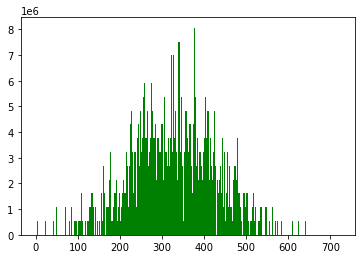

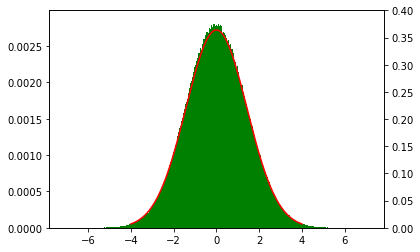

In [ ]:
#hide
#test subtract background distribution
from scipy.stats import norm
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import numpy as np

idx2nonnanvals = {}

for idx in range(2000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist1 = BackGroundDistribution(0, 999, idx2nonnanvals, idx2ion= dict(zip(idx2nonnanvals.keys(), idx2nonnanvals.keys())),p2z={})
bgdist2 = BackGroundDistribution(1000, 1999, idx2nonnanvals,idx2ion= dict(zip(idx2nonnanvals.keys(), idx2nonnanvals.keys())), p2z={})

freqdist = get_normed_freqs(bgdist1.cumulative)
plt.bar(range(len(freqdist)),freqdist,width=1,color='g')
plt.show()

subtracted_bgs = SubtractedBackgrounds(bgdist1, bgdist2, {})

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales


fc2counts_rescaled = tranform_fc2count_to_fc_space(subtracted_bgs.fc2counts, subtracted_bgs.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g')
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, subtracted_bgs.SD)*1.3, color = "red")
axes2.set_ylim(0.0, 0.4)
plt.show()

